In [93]:
# Image only classification Basic

In [148]:
import numpy as np
import pandas as pd
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16

In [149]:
conv_base = VGG16(weights='imagenet', include_top=False)

def read_image(file_path):
    image = load_img(file_path, target_size=(50, 50))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    val = conv_base.predict(image)
    print(val.shape)
    return val

In [150]:
df = pd.read_json('/home/jovyan/data/train.jsonl', lines=True)
df_test = pd.read_json('/home/jovyan/data/dev.jsonl', lines=True)
#df_test = pd.read_json('/home/jovyan/data/test.jsonl', lines=True)
df[df.label == 1].head(2)

,id,img,label,text
10,79351,img/79351.png,1,jew mad? get fuhrerious!
12,25489,img/25489.png,1,brother... a day without a blast is a day wasted


In [133]:
#df["image_data"] = df.apply(lambda x: read_image('/home/jovyan/data/' + x['img']), axis=1)
#df.to_pickle("df.pkl")

#df_test["image_data"] = df_test.apply(lambda x: read_image('/home/jovyan/data/' + x['img']), axis=1)
#df_test.to_pickle("df_test.pkl")

In [134]:
#df.head()

In [151]:
df = pd.read_pickle('df_224_224.pkl')

In [153]:
x =  np.vstack(df["image_data"])
y = df["label"]
#del df

In [154]:
#train_tensors, train_targets, valid_tensors, valid_targets = train_test_split(x, y, test_size=0.1, random_state=123)
train_features = x
train_labels = y

In [155]:
train_features.shape

(8500, 7, 7, 512)

In [157]:
df_test = pd.read_pickle('df_test_224_224.pkl')
validation_features =  np.vstack(df_test["image_data"])
validation_labels = df_test["label"]
del df_test

In [158]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(7,7,512)))
model1.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.summary()

# Compile model
model1.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history1 = model1.fit(train_features, train_labels,
                    epochs=10, 
                    batch_size=20, 
                    validation_split=.2, steps_per_epoch=300)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
300/300 [==============================] - 7s 24ms/step - loss: 0.7654 - acc: 0.6377 - val_loss: 0.6662 - val_acc: 0.5876
Epoch 2/10
300/300 [==============================] - 6s 19ms/step - loss: 0.6342 - acc: 0.6503 - val_loss: 

In [159]:
from keras import models
from keras import layers
from keras import optimizers

model2 = models.Sequential()
model2.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

# Compile model
model2.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history2 = model2.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=20, 
                    validation_split=.2, steps_per_epoch=300)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
300/300 [==============================] - 2s 5ms/step - loss: 0.6414 - acc: 0.6522 - val_loss: 0.6724 - val_acc: 0.5894
Epoch 2/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6351 - acc: 0.6565 - val_loss: 0.6784 - val_acc: 0.5888
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6313 - acc: 0.6562 - val_loss: 0.6916 - val_acc: 0.5882
Epoch 4/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6254 - acc: 0.6577 - val_loss: 0.6803 - val_a

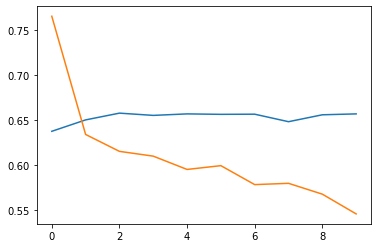

In [160]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['loss'])

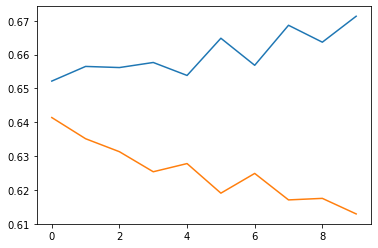

In [161]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['loss'])

In [164]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# get index of predicted dog breed for each image in test set
validation_pred = model2.predict(validation_features).ravel()
fpr_dev_keras, tpr_dev_keras, thresholds_dev_keras = roc_curve(validation_labels, validation_pred)
auc_dev_keras = auc(fpr_dev_keras, tpr_dev_keras)
print(auc_dev_keras)

0.51632


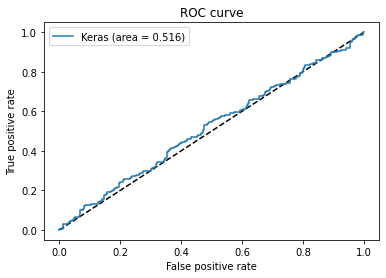

In [165]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dev_keras, tpr_dev_keras, label='Keras (area = {:.3f})'.format(auc_dev_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [166]:
df["image_data"][1].shape

(1, 7, 7, 512)